In [1]:
%% Start afresh by clearing all command windows and variables
clear;
rng(1); % For reproducibility

In [2]:
%% Load the paths..
run(['/work/imagingQ/SpatialAttention_Drowsiness/Jagannathan_Neuroimage2018/Scripts/' ...
    'loadpath_validation']);

In [3]:
%% Load the input files..
subject_ids = {'122'};

In [4]:
%% Load the eeglab data file and select the electrodes to be used..
subject = subject_ids{1};
   
%1. Preprocessed file -- > This contains the EEGlab preprocessed file
S.eeg_filepath = [pathappend 'SpatialAttention_Drowsiness/Jagannathan_Neuroimage2018/'...
                            'Preprocessed/Dataset_1'];
S.eeg_filename = [subject '_pretrial_preprocess'];

evalexp = 'pop_loadset(''filename'', [S.eeg_filename ''.set''], ''filepath'', S.eeg_filepath);';

%load the preprocessed EEGdata set..
[T,EEG] = evalc(evalexp);

% 1. Beh file --> Common for all subjects
S.beh_filepath = [pathappend 'SpatialAttention_Drowsiness/Jagannathan_Neuroimage2018/beh_data/'];
S.beh_filename = 'behfile';

load([S.beh_filepath S.beh_filename],'behdataset');

%Collect channel labels..
chanlabels={EEG.chanlocs.labels};
electrodes_occ = {'Oz','O1','O2'};

selec_elec = ismember(chanlabels,electrodes_occ);
remove_elec = find(~selec_elec);%Use only selected electrodes..
evalexp = 'pop_select(EEG,''nochannel'',remove_elec);';
[T,EEG_occ] = evalc(evalexp);
dur = (1/EEG.srate)*EEG.urevent(length(EEG.urevent)).latency;

EEG = EEG_occ;

In [5]:
%% Compute the power spectogram..
for idx = 1:EEG.nbchan

Data_x = squeeze(EEG.data(idx,:,:));
x = double(Data_x(:));

window_len = round(1*EEG.pnts);
nsc = window_len;
nov = floor(nsc/2);

[s,f,t,Pxx,fcorr,tcorr] = spectrogram(x,hamming(nsc),nov,nsc,EEG.srate,'yaxis','power');

time = linspace(0,dur,size(s,2));

freqlist = [0 40];
[~, fBeg] = min(abs(f-freqlist(1)));
[~, fEnd] = min(abs(f-freqlist(2)));

s_plot = s(fBeg:fEnd,:);
f_plot = f(fBeg:fEnd);
t_plot = t;
Pxx_plot(:,:,idx) = 10*log10(abs(Pxx(fBeg:fEnd,:)));

end

Pxx_plot = mean(Pxx_plot,3);

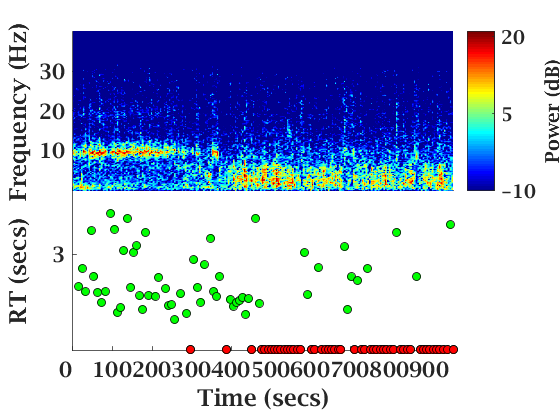

In [6]:
%% Plotting the data..
figure('rend','painters','pos',[10 10 700 600])
% Get the width and height of the figure
lbwh = get(1, 'position');
figw = lbwh(3);
figh = lbwh(4);

h = subplot(2,1,1);
ax1 = h;
hRotate = uigettool(ancestor(h,'Figure'),'Exploration.Rotate');
colormap jet
clims = [-10 max(max(Pxx_plot))];
hndl = pcolor(time, f_plot, Pxx_plot);
shading interp;
hndl.Parent.YDir = 'normal';
cblabel = getString(message('signal:dspdata:dspdata:PowerdB'));
h = colorbar;
h.Label.String = cblabel;
ylbl=['Frequency (Hz)'];
ylabel(ylbl);
t_plotval = 0:100:round(max(time));
f_plotval = 10:10:40;
set(gca, 'YTick', f_plotval);
set(gca, 'XTickLabel', []);
set(gca, 'YTickLabel', f_plotval);
set(gca, 'clim', clims);
set(h,'YTick',[-10:15:20]);
set(gca, 'FontName', 'Serif', 'FontSize', 16,'FontWeight','Bold');

hsp1 = get(gca, 'Position');
Trialtime = behdataset.TrialTime;
reactiontime = behdataset.ReactionTime;

ax2 = subplot(2,1,2);
scatter(time,nan(1,length(time)));
hold on ;s=scatter(Trialtime,reactiontime,'g','filled');
s.LineWidth = 0.6;
s.MarkerEdgeColor = 'k';
s.MarkerFaceColor = 'g';

hold on; s = scatter(Trialtime(reactiontime == 0),reactiontime(reactiontime==0),'r','filled');
s.LineWidth = 0.6;
s.MarkerEdgeColor = 'k';
s.MarkerFaceColor = 'r';

set(ax2,'Xlim',[0 round(max(time))]);
set(ax2,'XTick',t_plotval);
set(gca, 'YTick', [3]);
set(gca, 'YLim', [0, 5]);
set(gca, 'XTickLabel', [0 5]);
set(ax2, 'XTickLabel', t_plotval);
hsp2 = get(ax2, 'Position');                   % Get 'Position' for (2,1,2)
set(ax2, 'Position', [1*hsp2(1) 1.5*hsp2(2) hsp1(3) 1*hsp2(4)]);
xlbl=['Time (secs)'];
ylbl=['RT (secs)'];
ylabel(ylbl);
xlabel(xlbl);
set(gca, 'FontName', 'Serif', 'FontSize', 16,'FontWeight','Bold');
set(gca, 'color', [0.9 0.9 0.9])

samexaxis('xmt','off','ytac','join','yld',1)
%linkaxes([ax1,ax2],'x')